The goal of this challenge is to look at user purchase history and create categories of items that are likely to be bought together and, therefore, should belong to the same section.

In [151]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

%matplotlib inline

In [6]:
# read data
item_to_id = pd.read_csv('/Users/kexinluo/Desktop/DS_take_home/9.grocery cluster/item_to_id.csv')
print(item_to_id.shape)
item_to_id.head()

(48, 2)


,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [126]:
item_to_id['Item_id']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Item_name  48 non-null     object
 1   Item_id    48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


In [7]:
purchase_history = pd.read_csv('/Users/kexinluo/Desktop/DS_take_home/9.grocery cluster/purchase_history.csv')
print(purchase_history.shape)
purchase_history.head()

(39474, 2)


,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [11]:
print(f"Number of unique items: {len(set(item_to_id['Item_id']))}")
print(f"Number of unique users: {len(set(purchase_history['user_id']))}")
# Some users have multiple purchases

Number of unique items: 48
Number of unique users: 24885


# Constructing user-item purchasing table

Construct a table with user id in the rows and item id as columns, each row record a user's purchasing history: how many purchases has he/she made for each item?

In [109]:
unique_user_id = list(set(purchase_history['user_id']))
unique_user_id = [int(x) for x in unique_user_id]
unique_user_id.sort()
unique_item_id = list(set(item_to_id['Item_id']))
unique_item_id = [str(x) for x in unique_item_id]
user_item = []
for u_id in unique_user_id:
    temp = purchase_history[purchase_history['user_id'] == u_id]
    purchases = temp['id'].str.split(',').sum()
    counts = Counter(purchases)
    items = []
    for it in unique_item_id:
        items.append(counts[it])
    user_item.append(items)


In [110]:
user_item_df = pd.DataFrame(user_item, columns = unique_item_id)
user_item_df['user_id'] = unique_user_id
user_item_df.set_index("user_id", inplace=True)
user_item_df.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


# Question 1

## The customer who bought the most items overall in her lifetime

In [111]:
user_count = user_item_df.sum(axis=1).reset_index().rename(columns={0: 'count'})
user_count.sort_values(by='count', ascending=False).head()

,user_id,count
4445,269335,72
6111,367872,70
6623,397623,64
9918,599172,64
6291,377284,63


So the customer who bought the most items is 269335 with 72 items

## For each item, the customer who bought that product the most

In [131]:
user_idx = user_item_df.apply(np.argmax, axis=0)

item_purchase_most = pd.DataFrame({'Item_id' : [int(x) for x in unique_item_id], 'user_id' : user_item_df.index[user_idx].tolist(), 'item_max_num': user_item_df.apply(max, axis=0)})
item_purchase_most = pd.merge(left=item_purchase_most, right=item_to_id, on='Item_id', how='left')
item_purchase_most

,Item_id,user_id,item_max_num,Item_name
0,1,31625,4,sugar
1,2,31625,5,lettuce
2,3,154960,4,pet items
3,4,5289,3,baby items
4,5,217277,3,waffles
5,6,334664,4,poultry
6,7,175865,3,sandwich bags
7,8,151926,3,butter
8,9,269335,4,soda
9,10,618914,4,carrots


# Question 2

In [148]:
# first construct a matrix recording each purchase

unique_item_id = list(set(item_to_id['Item_id']))
unique_item_id = [str(x) for x in unique_item_id]
purchase_item = []
for i in range(0,purchase_history.shape[0]):
    temp = purchase_history.iloc[i]
    purchases = temp['id'].split(',')
    counts = Counter(purchases)
    items = []
    for it in unique_item_id:
        items.append(counts[it])
    purchase_item.append(items)


In [149]:
purchase_item_df = pd.DataFrame(purchase_item, columns = unique_item_id)
purchase_item_df

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,1,1,0,0,1,0,1,0,0,0,...,0,1,0,1,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39469,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,1
39470,0,0,0,0,0,0,0,0,1,0,...,0,1,1,0,1,0,0,1,1,0
39471,1,1,1,1,0,0,0,0,0,1,...,1,0,0,0,1,1,0,0,1,0
39472,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [152]:
# transpose the df
purchase_item_df = purchase_item_df.T
purchase_item_df.head()

,0,1,2,3,4,5,6,7,8,9,...,39464,39465,39466,39467,39468,39469,39470,39471,39472,39473
1,0,0,1,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,1,1,0
2,0,0,0,1,1,0,0,0,0,1,...,1,1,0,0,0,1,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Use K-means to do clustering

In [154]:
# determine the best number of clusters
clusters = range(2, 30)
inertias = []
silhouettes = []

for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans = kmeans.fit(purchase_item_df)
    label = kmeans.predict(purchase_item_df)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(purchase_item_df, label))

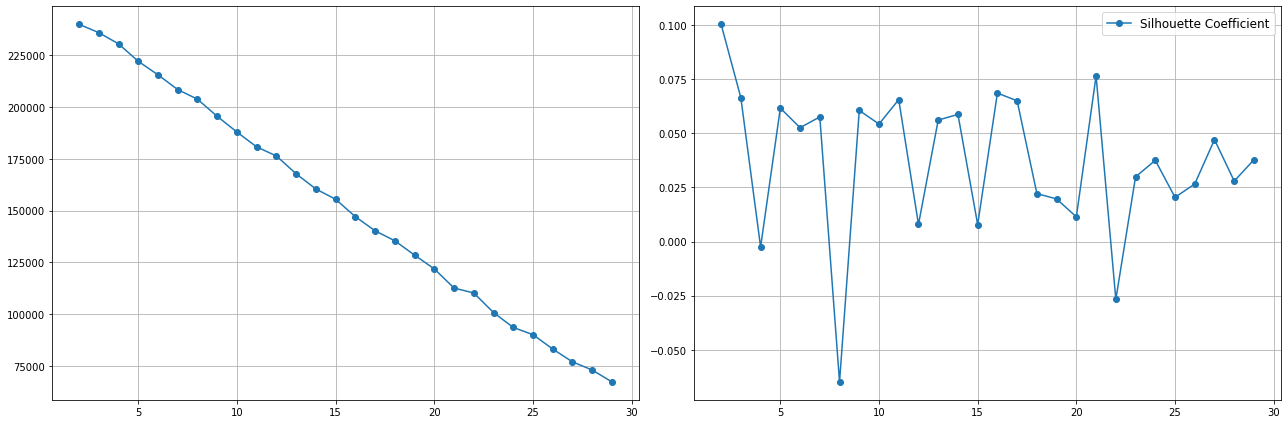

In [155]:
# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Coefficient')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Neither method gives a hint about which cluster number is optimum. Try 15.

In [158]:
# build K-Means model
kmeans = KMeans(n_clusters=15, random_state=42)
kmeans = kmeans.fit(purchase_item_df)
label = kmeans.predict(purchase_item_df)


In [159]:
# PCA for dimension reduction
pca = PCA(n_components=2, random_state=42)
pca = pca.fit(purchase_item_df)
pca_feature = pca.transform(purchase_item_df)

/var/folders/nt/z1npcmws4ld703g3hhm7p1p00000gn/T/ipykernel_69410/1614318324.py:10: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.annotate(xy=(x+0.2, y+0.2), s=name.values[0], fontsize=10)


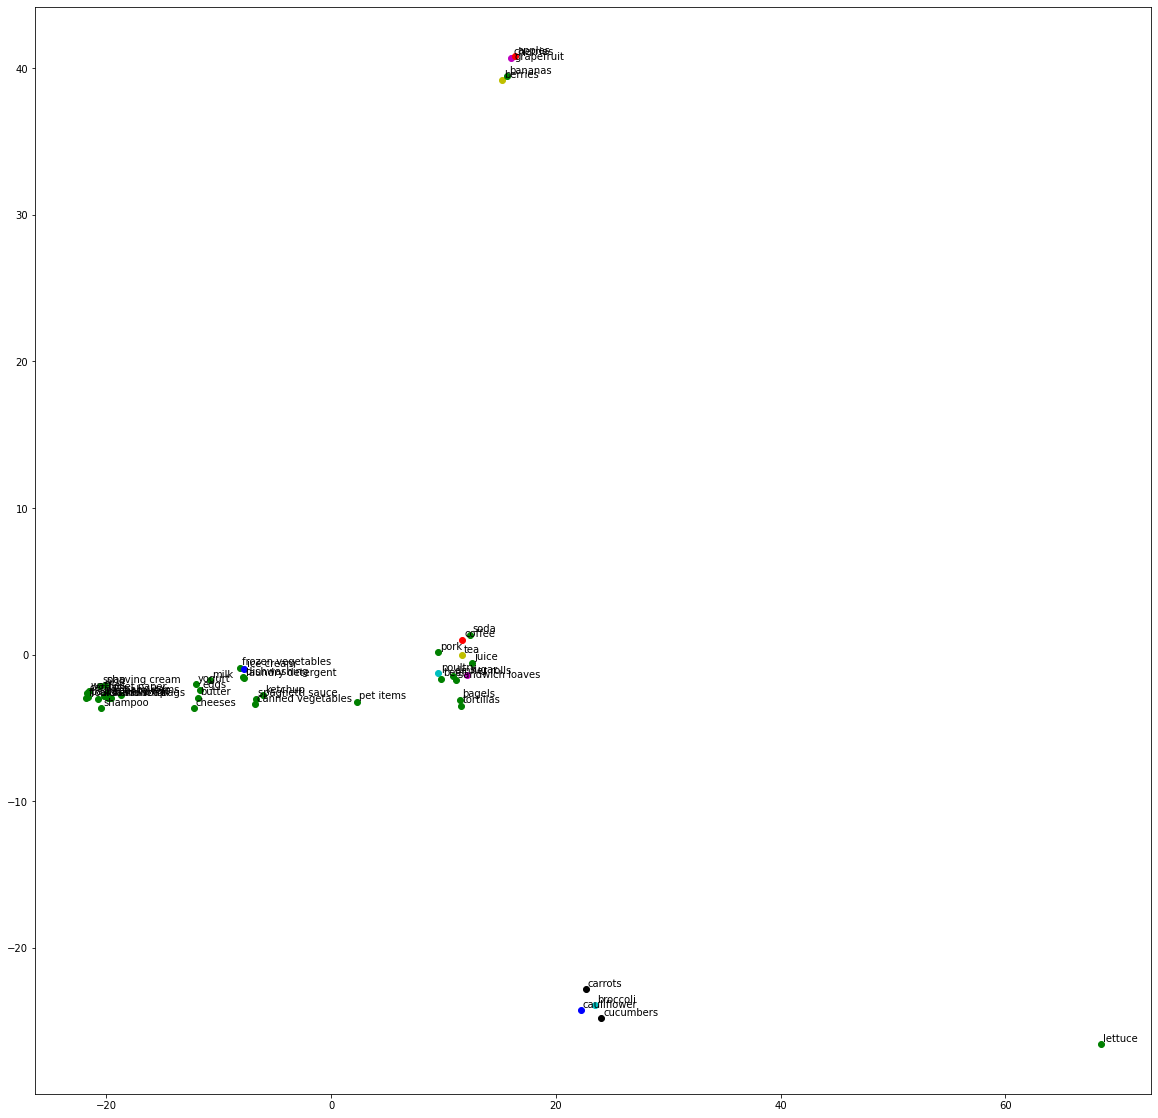

In [162]:
# visualization in 2D
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, ax = plt.subplots(figsize=(20, 20))
for j in range(len(pca_feature)):
    x = pca_feature[j][0]
    y = pca_feature[j][1]
    ax.plot(x, y, 'o', color=colors[label[j] % 8])
    name = item_to_id[item_to_id['Item_id'] == j + 1]['Item_name']
    ax.annotate(xy=(x+0.2, y+0.2), s=name.values[0], fontsize=10)

plt.show()